In [1]:
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Get The Train and Test Features

In [2]:
trainfeatures_df = pd.read_csv('train.csv')
testfeatures_df = pd.read_csv('last_purchases.csv')
test_df = pd.read_csv('yzv311e_term_project_fall_24_25/test.csv')

In [3]:
X = trainfeatures_df.drop(['target','repurchase'], axis=1)

Y = trainfeatures_df['repurchase']

X

,quantity,highest_level,recency,frequency,month,month_part,span,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,purchase_cycle,purchase_cycle_scaled
0,1,2012,6,18,12,2,234,4,0,18,0,81,0.0,0.0
1,1,2346,6,18,6,1,234,4,0,284,0,66,0.0,0.0
2,1,2346,6,18,10,2,234,4,0,284,0,66,19.0,19.0
3,1,1682,6,18,11,3,234,4,3,468,3,108,0.0,0.0
4,1,1682,6,18,12,2,234,4,3,468,3,108,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174589,1,1072,17,25,11,2,148,4,0,486,0,48,0.0,0.0
174590,1,1682,8,29,7,4,181,4,0,291,0,44,0.0,0.0
174591,4,2364,34,35,6,4,209,4,3,321,0,144,0.0,0.0
174592,5,2364,34,35,6,4,209,10,0,345,0,84,0.0,0.0


## Train The Network For Repurchase or Not

In [4]:
# Split data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)

In [5]:

# ---------------------- CatBoost ----------------------
catboost_repurchase_model = cb.CatBoostClassifier(
    learning_rate=0.1,
    depth=10,
    eval_metric='AUC',
    iterations=1000,
    cat_features=['attribute_1', 'attribute_2', 'attribute_3', 'attribute_4', 
                  'attribute_5', 'highest_level', 'month', 'month_part'],
    class_weights={0: 1, 1: 2.5},
    early_stopping_rounds=50,
    verbose=100
)

catboost_repurchase_model.fit(X_train, Y_train, eval_set=(X_val, Y_val), use_best_model=True, verbose=100)
catboost_preds = catboost_repurchase_model.predict_proba(X_val)[:, 1]
catboost_auc = roc_auc_score(Y_val, catboost_preds)
print(f"CatBoost AUC: {catboost_auc}")

0:	test: 0.7272559	best: 0.7272559 (0)	total: 656ms	remaining: 10m 55s
100:	test: 0.7832234	best: 0.7838593 (81)	total: 49.3s	remaining: 7m 19s
200:	test: 0.7864500	best: 0.7868124 (190)	total: 1m 40s	remaining: 6m 39s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7868124493
bestIteration = 190

Shrink model to first 191 iterations.
CatBoost AUC: 0.7868124492934316


In [6]:

# ---------------------- XGBoost ----------------------
xgb_repurchase_model = xgb.XGBClassifier(
    learning_rate=0.1,
    max_depth=10,
    n_estimators=1000,
    objective='binary:logistic',
    scale_pos_weight=2.5,
    eval_metric='auc',
    early_stopping_rounds=50,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    verbosity=0
)

xgb_repurchase_model.fit(X_train, Y_train, eval_set=[(X_val, Y_val)],verbose=False)
xgb_preds = xgb_repurchase_model.predict_proba(X_val)[:, 1]
xgb_auc = roc_auc_score(Y_val, xgb_preds)
print(f"XGBoost AUC: {xgb_auc}")

XGBoost AUC: 0.79087605876593


In [7]:

# ---------------------- LightGBM ----------------------
lgb_repurchase_model = lgb.LGBMClassifier(
    learning_rate=0.1,
    max_depth=10,
    n_estimators=1000,
    class_weight={0: 1, 1: 2.5},  # Handle class imbalance
    metric='auc',
    boosting_type='gbdt',
    early_stopping_round=50,
    verbose=100
)

lgb_repurchase_model.fit(X_train, Y_train, eval_set=[(X_val, Y_val)], eval_metric='auc')
lgb_preds = lgb_repurchase_model.predict_proba(X_val)[:, 1]
lgb_auc = roc_auc_score(Y_val, lgb_preds)
print(f"LightGBM AUC: {lgb_auc}")

# ---------------------- Model Comparison ----------------------
model_scores = {
    'CatBoost': catboost_auc,
    'XGBoost': xgb_auc,
    'LightGBM': lgb_auc
}

best_model_name = max(model_scores, key=model_scores.get)
best_auc = model_scores[best_model_name]

print(f"Best Model: {best_model_name} with AUC: {best_auc}")

[LightGBM] [Info] Number of positive: 23383, number of negative: 133751
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.693002
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.203892
[LightGBM] [Debug] init for col-wise cost 0.005370 seconds, init for row-wise cost 0.008087 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1320
[LightGBM] [Info] Number of data points in the train set: 157134, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304136 -> initscore=-0.827680
[LightGBM] [Info] Start training from score -0.827680
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
Training until validation scores don't improve for 50 rounds
[LightGBM] [

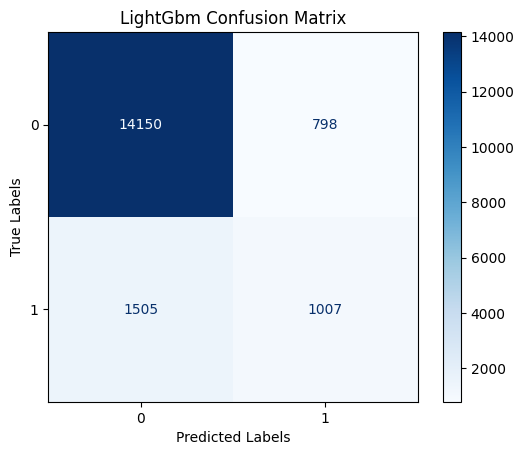

In [8]:
lgb_predictions = lgb_repurchase_model.predict(X_val)
# Compute the confusion matrix
cm = confusion_matrix(Y_val, lgb_predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d') 
plt.title('LightGbm Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

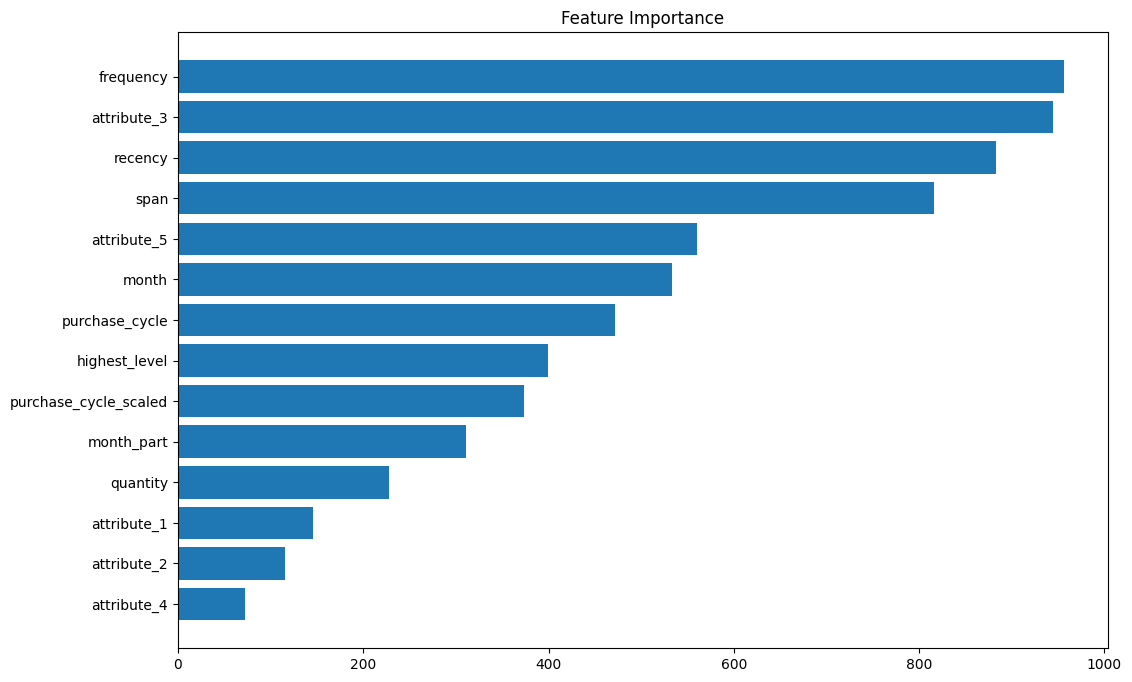

In [9]:
# Get feature importance
feature_importance = lgb_repurchase_model.feature_importances_

# Create a DataFrame
feature_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})

# Sort values by importance
feature_df = feature_df.sort_values('Importance', ascending=True)

# Plot the feature importance
plt.figure(figsize=(12, 8))
plt.barh(feature_df['Feature'], feature_df['Importance'])
plt.title('Feature Importance')
plt.show()

In [10]:
# Merge the test features with the test data
merged_df = test_df.merge(testfeatures_df, on=['customer_id', 'product_id'], how='left')


cat_features = ['attribute_1', 'attribute_2', 'attribute_3', 'attribute_4', 'attribute_5', 'highest_level','month','month_part']
train_features = X.columns

merged_df = merged_df.drop(columns=['id','prediction'])[train_features]
# predict the target

test_pred = lgb_repurchase_model.predict(merged_df)

test_df['prediction'] = test_pred.astype(int)  # Adjust labels to start from 1

test_df['prediction'].value_counts()



prediction
1    5937
0    4063
Name: count, dtype: int64

## Train The Network on Week Prediction

In [11]:
X = trainfeatures_df.loc[trainfeatures_df['target'] != 0].drop(['target','repurchase'], axis=1)


Y = trainfeatures_df.loc[trainfeatures_df['target'] != 0]['target']
X

,quantity,highest_level,recency,frequency,month,month_part,span,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,purchase_cycle,purchase_cycle_scaled
3,1,1682,6,18,11,3,234,4,3,468,3,108,0.000000,0.0
5,1,1072,15,15,11,2,193,4,0,491,-1,89,0.000000,0.0
49,1,2364,6,49,11,4,216,4,0,474,-1,108,12.000000,12.0
50,1,2364,6,49,12,4,216,4,0,474,-1,108,8.000000,8.0
51,3,2346,6,49,12,3,216,6,0,497,3,-1,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174537,1,2364,8,31,10,4,185,4,0,491,3,154,6.500000,6.5
174543,1,2364,8,31,10,4,185,4,0,491,3,154,6.500000,6.5
174548,1,34,0,16,12,4,241,6,0,491,3,46,0.000000,0.0
174555,2,1072,48,25,11,4,160,4,0,485,3,154,7.666667,5.0


In [12]:
# ---------------------- Data Preparation ----------------------

# Adjust labels to start from 0 (shift classes: 1 → 0, 2 → 1, etc.)
Y_adjusted = Y - 1

# Calculate class weights for imbalance handling
class_weights = Y_adjusted.value_counts(normalize=True)
weights = 1 / class_weights
sample_weights = Y_adjusted.map(weights)

# Split data into training and validation sets
X_train, X_val, Y_train, Y_val, W_train, W_val = train_test_split(
    X, Y_adjusted, sample_weights, test_size=0.1, random_state=42
)

# ---------------------- XGBoost ----------------------
xgb_week_model = xgb.XGBClassifier(
    objective='multi:softprob',  # Multi-class classification
    learning_rate=0.1,
    max_depth=10,
    n_estimators=1000,
    eval_metric='mlogloss',  # Multi-class log loss
    num_class=4,  # Number of classes
    verbosity=1,
    early_stopping_rounds=50
)

# Train model with sample weights
xgb_week_model.fit(
    X_train, Y_train,
    sample_weight=W_train,
    eval_set=[(X_val, Y_val)],
    verbose=50,  # Log every 50 iterations
)

# Predict probabilities
xgb_preds = xgb_week_model.predict_proba(X_val)
xgb_auc = roc_auc_score(Y_val, xgb_preds, multi_class='ovr')  # One-vs-Rest AUC
print(f"XGBoost AUC: {xgb_auc}")


[0]	validation_0-mlogloss:1.37038
[50]	validation_0-mlogloss:1.23343
[100]	validation_0-mlogloss:1.20445
[150]	validation_0-mlogloss:1.19876
[200]	validation_0-mlogloss:1.20205
XGBoost AUC: 0.687264287237257


In [13]:

# ---------------------- LightGBM ----------------------
lgb_week_model = lgb.LGBMClassifier(
    boosting_type='gbdt',
    learning_rate=0.1,
    max_depth=10,
    n_estimators=1000,
    objective='multiclass',  # Multi-class classification
    class_weight='balanced',  # Handle imbalance automatically
    num_class=4,
    metric='multi_logloss',
    verbose=50,
    early_stopping_rounds=50
)

# Train model
lgb_week_model.fit(
    X_train, Y_train,
    sample_weight=W_train,
    eval_set=[(X_val, Y_val)],
    eval_metric='multi_logloss'
)

# Predict probabilities
lgb_preds = lgb_week_model.predict_proba(X_val)
lgb_auc = roc_auc_score(Y_val, lgb_preds, multi_class='ovr')
print(f"LightGBM AUC: {lgb_auc}")


[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.723471
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.179842
[LightGBM] [Debug] init for col-wise cost 0.000631 seconds, init for row-wise cost 0.002078 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1284
[LightGBM] [Info] Number of data points in the train set: 23305, number of used features: 14
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score -0.827696
[LightGBM] [Info] Start

In [14]:

# ---------------------- CatBoost ----------------------
catboost_week_model = cb.CatBoostClassifier(
    learning_rate=0.1,
    depth=10,
    iterations=1000,
    eval_metric='MultiClass',
    loss_function='MultiClass',
    class_weights=weights.to_dict(),  # Pass weights directly
    early_stopping_rounds=50,
    verbose=100,
    cat_features=['attribute_1', 'attribute_2', 'attribute_3', 'attribute_4', 
                  'attribute_5', 'highest_level', 'month', 'month_part']
)

# Train model
catboost_week_model.fit(
    X_train, Y_train,
    sample_weight=W_train,
    eval_set=(X_val, Y_val),
    use_best_model=True,
    verbose=50
)

# Predict probabilities
catboost_preds = catboost_week_model.predict_proba(X_val)
catboost_auc = roc_auc_score(Y_val, catboost_preds, multi_class='ovr')
print(f"CatBoost AUC: {catboost_auc}")

# ---------------------- Model Comparison ----------------------
model_scores = {
    'XGBoost': xgb_auc,
    'LightGBM': lgb_auc,
    'CatBoost': catboost_auc
}

best_model_name = max(model_scores, key=model_scores.get)
best_auc = model_scores[best_model_name]

print(f"Best Model: {best_model_name} with AUC: {best_auc}")

0:	learn: 1.3647276	test: 1.3882557	best: 1.3882557 (0)	total: 121ms	remaining: 2m
50:	learn: 1.2015468	test: 1.4342954	best: 1.3882557 (0)	total: 20.9s	remaining: 6m 29s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.388255729
bestIteration = 0

Shrink model to first 1 iterations.
CatBoost AUC: 0.5034601190845374
Best Model: XGBoost with AUC: 0.687264287237257


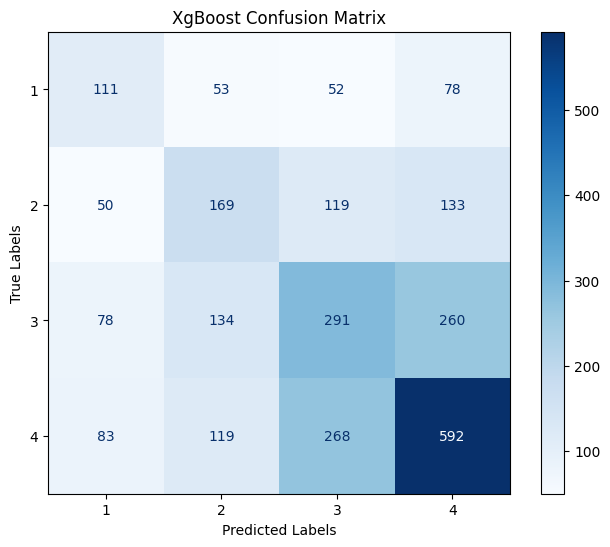

In [15]:
# Predictions
xgb_predictions = xgb_week_model.predict(X_val)

# Compute the confusion matrix
cm = confusion_matrix(Y_val, xgb_predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot with adjustments
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d', ax=ax)  

# Set custom axis labels starting from 1 (instead of 0)
num_classes = cm.shape[0]
tick_labels = [str(i+1) for i in range(num_classes)]
ax.set_xticks(range(num_classes))
ax.set_yticks(range(num_classes))
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)

# Titles and labels
plt.title('XgBoost Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.show()

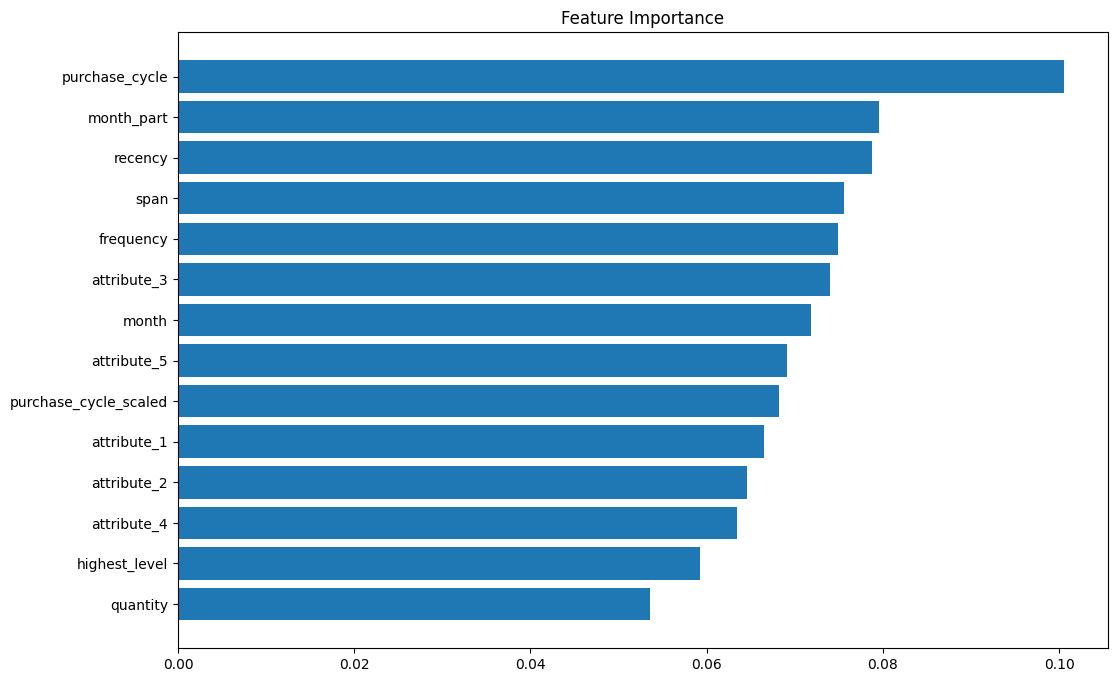

In [16]:
# Get feature importance
feature_importance = xgb_week_model.feature_importances_

# Create a DataFrame
feature_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})

# Sort values by importance
feature_df = feature_df.sort_values('Importance', ascending=True)

# Plot the feature importance
plt.figure(figsize=(12, 8))
plt.barh(feature_df['Feature'], feature_df['Importance'])
plt.title('Feature Importance')
plt.show()

In [17]:
# Preprocess: Merge last_purchases and train_df upfront
week_merged_df = test_df[test_df['prediction']==1].merge(testfeatures_df, on=['customer_id', 'product_id'], how='left')

# Get feature names used during training
train_features = X.columns
# Drop duplicates
week_merged_df = week_merged_df.drop(columns=['id','prediction'])[train_features]


# Ensure test features match training order
test_pred = lgb_week_model.predict(week_merged_df)

test_df.loc[test_df['prediction'] != 0, 'prediction'] = test_pred + 1 # Adjust labels to start from 1
test_df['prediction'].value_counts()


prediction
0    4033
1    2627
2    1443
3    1034
4     863
Name: count, dtype: int64

In [18]:
# Save the predictions
test_df.to_csv('submission.csv', index=False)